In [20]:
# Imports and Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import random
import os
from obspy.core import read
from sklearn.model_selection import train_test_split
from spectrogram_to_array import spectrogram
import time
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

In [3]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Using device: cuda
CUDA available: True
CUDA version: 12.4
Current device: 0
Device name: NVIDIA GeForce MX250


In [6]:
# Loading Event Data

# Path setup
main_path = os.path.abspath("")
all_events_file_path = os.path.join(main_path, 'earthquakes_filtered.txt')  # all events
all_events = pd.read_csv(all_events_file_path, sep=',')

try:
    all_events.drop(columns=['Unnamed: 0'], inplace=True)  # automatically created column (idk why)
except:
    pass

all_events.head()


,event_id,event_ID,year,month,day,hour,minute,second,lat,lng,depth,mag_ML,std_dev_ML,mag_MA,std_dev_MA,category
0,0,0,2007,1,1,2,41,13.28,-21.65559,-68.41471,121.33,2.345,0.020,2.394,0.029,0
1,1,1,2007,1,1,2,47,7.83,-20.54848,-69.05857,102.79,1.114,0.033,1.305,0.031,0
2,2,2,2007,1,1,3,50,29.15,-21.86299,-68.53639,110.95,2.779,0.031,2.917,0.031,0
3,3,3,2007,1,1,4,19,27.82,-20.29515,-69.13106,95.79,1.401,0.017,1.571,0.023,0
4,4,4,2007,1,1,5,40,2.58,-21.23847,-70.05151,34.64,1.995,0.022,2.222,0.018,0


In [79]:
# Prepare Dataset

# Preparing file list from geofon_waveforms folder
dataset_size = 2000
file_list = os.listdir(os.path.join(main_path, "geofon_waveforms"))
file_list = [int(file[:-6]) for file in file_list if file.endswith(".mseed")]

# Select random sample of N events from all files
file_list = random.sample(file_list, dataset_size)

# Train-test split
train_events, test_events = train_test_split(file_list, test_size=0.2, random_state=42)

# Merge with events data
train_events = pd.DataFrame(train_events, columns=['event_id']).merge(all_events, on='event_id')
test_events = pd.DataFrame(test_events, columns=['event_id']).merge(all_events, on='event_id')

In [81]:
# Helper Functions

def normalize_tensor(tensor):
    mean = tensor.mean()
    std = tensor.std()
    return (tensor - mean) / (std + 1e-6)  # Add epsilon to avoid division by zero

class EventDataset(Dataset):
    def __init__(self, dataframe, data_directory, transform=None):
        self.dataframe = dataframe  # The DataFrame containing event IDs and labels
        self.data_directory = data_directory  # Directory containing waveform files
        self.transform = transform  # Optional preprocessing function

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        event_id, label = int(row['event_id']), int(row['category'])

        # Load waveform
        file_name = f"{event_id}.mseed"
        waveform_path = os.path.join(self.data_directory, file_name)
        waveform = read(waveform_path)

        # Concatenate waveform data from all channels
        waveform_data = np.concatenate([trace.data for trace in waveform], axis=0).astype(np.float32)

        # Apply transformation (e.g., normalization) if provided
        if self.transform:
            waveform_data = self.transform(waveform_data)

        return {'label': label, 'data': waveform_data}


In [83]:
# Define directories
data_directory = os.path.join(main_path, "geofon_waveforms")

# Define batch size
batch_size = 4  # Adjust this value as needed

# Create datasets and loaders
train_dataset = EventDataset(train_events, "geofon_waveforms", transform=normalize_tensor)
test_dataset = EventDataset(test_events, "geofon_waveforms", transform=normalize_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [85]:
# Feature Extraction
start_time = time.time()

print("Extracting features...")
train_features, train_labels = [], []
test_features, test_labels = [], []

for sample in tqdm(train_loader, desc="Processing Training Data"):
    data = sample['data']
    labels = sample['label']
    train_features.append(data.numpy())
    train_labels.append(labels.numpy())

train_features = np.concatenate(train_features)
train_labels = np.concatenate(train_labels)

for sample in tqdm(test_loader, desc="Processing Test Data"):
    data = sample['data']
    labels = sample['label']
    test_features.append(data.numpy())
    test_labels.append(labels.numpy())

test_features = np.concatenate(test_features)
test_labels = np.concatenate(test_labels)

end_time = time.time()

print(f"Feature extraction completed in: {end_time - start_time:.2f} seconds")

Extracting features...


Processing Test Data: 100%|██████████| 100/100 [00:02<00:00, 37.42it/s]

Feature extraction completed in: 13.95 seconds


In [86]:
# Optimize PCA Components
results = []
min_variance_ratio = 0.80

print("\nOptimizing PCA components...")
start_time_pca = time.time()  # Start timing PCA component optimization
for n_components in range(30, 50):
    step_start = time.time()  # Start timing for each iteration

    # Apply PCA
    pca = PCA(n_components=n_components)
    train_features_pca = pca.fit_transform(train_features)
    test_features_pca = pca.transform(test_features)
    explained_variance_ratio = np.sum(pca.explained_variance_ratio_)

    # Train SVM
    svm = SGDClassifier(loss='hinge', max_iter=1000000000, tol=1e-3, warm_start=False, n_jobs=-1)
    svm.fit(train_features_pca, train_labels)

    # Evaluate Accuracy
    accuracy = accuracy_score(test_labels, svm.predict(test_features_pca))
    results.append((n_components, accuracy, explained_variance_ratio))

    step_end = time.time()  # End timing for this iteration
    print(f"Components: {n_components}, Accuracy: {accuracy:.2f}, Variance Ratio: {explained_variance_ratio:.2f}, Time: {step_end - step_start:.2f} seconds")

end_time_pca = time.time()  # End timing PCA component optimization
print(f"PCA components optimization completed in: {end_time_pca - start_time_pca:.2f} seconds")

results_df = pd.DataFrame(results, columns=['n_components', 'accuracy', 'explained_variance_ratio'])
filtered_results = results_df[results_df['explained_variance_ratio'] >= min_variance_ratio]

if not filtered_results.empty:
    optimal_row = filtered_results.loc[filtered_results['accuracy'].idxmax()]
else:
    print("No configurations met the minimum variance threshold.")
    optimal_row = results_df.loc[results_df['accuracy'].idxmax()]

optimal_components = int(optimal_row['n_components'])
print(f"Optimal components: {optimal_components}")


Optimizing PCA components...
Components: 30, Accuracy: 0.89, Variance Ratio: 0.77, Time: 0.52 seconds
Components: 31, Accuracy: 0.90, Variance Ratio: 0.77, Time: 0.64 seconds
Components: 32, Accuracy: 0.88, Variance Ratio: 0.77, Time: 0.51 seconds
Components: 33, Accuracy: 0.89, Variance Ratio: 0.78, Time: 0.60 seconds
Components: 34, Accuracy: 0.89, Variance Ratio: 0.78, Time: 0.52 seconds
Components: 35, Accuracy: 0.90, Variance Ratio: 0.78, Time: 0.62 seconds
Components: 36, Accuracy: 0.90, Variance Ratio: 0.79, Time: 0.56 seconds
Components: 37, Accuracy: 0.89, Variance Ratio: 0.79, Time: 0.61 seconds
Components: 38, Accuracy: 0.90, Variance Ratio: 0.79, Time: 0.53 seconds
Components: 39, Accuracy: 0.89, Variance Ratio: 0.80, Time: 0.57 seconds
Components: 40, Accuracy: 0.90, Variance Ratio: 0.80, Time: 0.56 seconds
Components: 41, Accuracy: 0.88, Variance Ratio: 0.80, Time: 0.71 seconds
Components: 42, Accuracy: 0.90, Variance Ratio: 0.80, Time: 0.61 seconds
Components: 43, Accur


Optimizing SGDClassifier alpha parameter...
Alpha: 0.000010, Train Accuracy: 0.91, Test Accuracy: 0.90, Time: 0.02 seconds
Alpha: 0.000026, Train Accuracy: 0.87, Test Accuracy: 0.86, Time: 0.02 seconds
Alpha: 0.000070, Train Accuracy: 0.91, Test Accuracy: 0.90, Time: 0.01 seconds
Alpha: 0.000183, Train Accuracy: 0.89, Test Accuracy: 0.86, Time: 0.02 seconds
Alpha: 0.000483, Train Accuracy: 0.91, Test Accuracy: 0.89, Time: 0.03 seconds
Alpha: 0.001274, Train Accuracy: 0.91, Test Accuracy: 0.90, Time: 0.02 seconds
Alpha: 0.003360, Train Accuracy: 0.90, Test Accuracy: 0.86, Time: 0.02 seconds
Alpha: 0.008859, Train Accuracy: 0.91, Test Accuracy: 0.89, Time: 0.02 seconds
Alpha: 0.023357, Train Accuracy: 0.89, Test Accuracy: 0.85, Time: 0.01 seconds
Alpha: 0.061585, Train Accuracy: 0.91, Test Accuracy: 0.89, Time: 0.01 seconds
Alpha: 0.162378, Train Accuracy: 0.91, Test Accuracy: 0.90, Time: 0.01 seconds
Alpha: 0.428133, Train Accuracy: 0.91, Test Accuracy: 0.89, Time: 0.02 seconds
Alpha: 

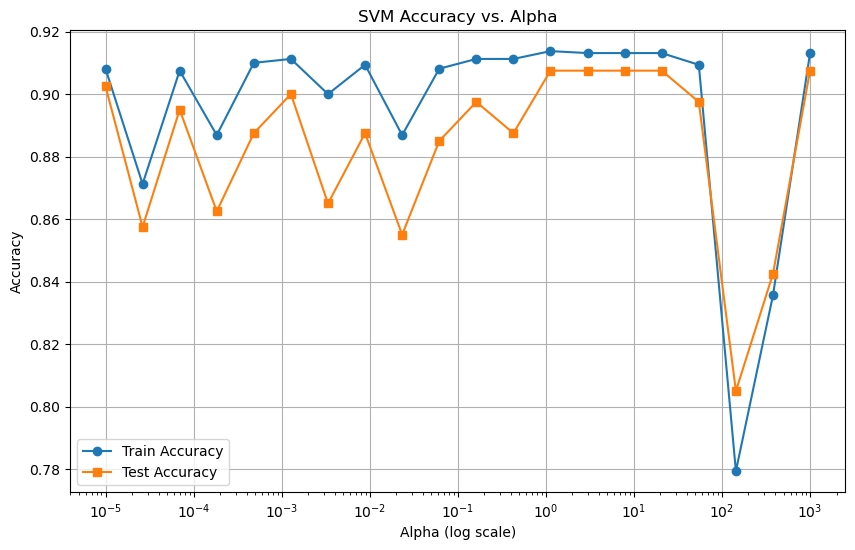

In [87]:
# Final PCA and Alpha Optimization
pca = PCA(n_components=optimal_components)
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)

alpha_values = np.logspace(-5, 3, 20)
train_accuracies, test_accuracies = [], []
best_alpha, best_test_accuracy = None, 0

print("\nOptimizing SGDClassifier alpha parameter...")
start_time_alpha = time.time()  # Start timing alpha optimization
for idx, alpha in enumerate(alpha_values):
    step_start = time.time()  # Start timing for each alpha iteration

    # Train SVM
    svm = SGDClassifier(loss='hinge', alpha=alpha, max_iter=1000000000, tol=1e-3, warm_start=False, n_jobs=-1)
    svm.fit(train_features_pca, train_labels)

    # Evaluate Accuracy
    train_acc = accuracy_score(train_labels, svm.predict(train_features_pca))
    test_acc = accuracy_score(test_labels, svm.predict(test_features_pca))
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    # Update best alpha
    if test_acc > best_test_accuracy:
        best_test_accuracy = test_acc
        best_alpha = alpha

    step_end = time.time()  # End timing for this alpha iteration
    print(f"Alpha: {alpha:.6f}, Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}, Time: {step_end - step_start:.2f} seconds")

end_time_alpha = time.time()  # End timing alpha optimization
print(f"Alpha optimization completed in: {end_time_alpha - start_time_alpha:.2f} seconds")

# Print Best Alpha
print(f"\nBest alpha: {best_alpha:.6f} with Test Accuracy: {best_test_accuracy * 100:.2f}%")

# Plot Accuracy vs Alpha
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(alpha_values, test_accuracies, label='Test Accuracy', marker='s')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy vs. Alpha')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
# Save Final Model
final_model = SGDClassifier(loss='hinge', alpha=best_alpha, max_iter=1000000000, tol=1e-3, warm_start=False, n_jobs=-1)
final_model.fit(train_features_pca, train_labels)
torch.save(final_model, "pca_svm_model.pth")
print("Final model saved.")

Final model saved.
